# Coding Bootcamp II - `xarray` and gridded data

Ivan Higuera-Mendieta - ivanhigueram@uchicago.edu

Until now we have discussed data on different formats. Many of the data libraries we have covered until now share a lot of functionalities (i.e. similar indexing features). This is part explained by the broad use of `numpy` across many Python libraries. In today's session we will cover one pretty handy library that allow us to easily used unlabelled n-dimensional arrays and bring us also the chance of processing larger-than-memory dataset without the need of fancy intrastructure (i.e. Spark or NoSQL databases).

Unlabelled, N-dimensional arrays of numbers are frequently used data structure in scientific computing. For example, sets of climate variables (e.g. temperature and precipitation) that vary in space and time and are represented on a regularly-spaced grid. Often we need to subset a large global grid to look at data for a particular region, or select a specific time slice. Then we might want to apply statistical functions to these subsetted groups to generate summary information 

We will divide today's lesson in four sections: 

1. Intoduction to `xarray`

2. Indexing and selecting data

3. Computation

4. Some advance cases using `Dask`

5. Data sources (with our invited instructor, Jim Franke)

# Section 1 - What's `xarray`?

This library is a more organized and less error-prone of handdling multi-dimensional data. In `xarray` multi-dimensional arrays have named coordinates (that thing we called `axis` on both `pandas` and `numpy`). 

This is not the only library that works with names arrays. In a way, `pandas` offer also that functionality, but the tabular format of rows and columns is restrictive and doesn't allow to easily vectorize operations. Many other libraries offer similar functions, starting with [DataArray][2]. 
 
 [2]: https://github.com/BIDS/datarray



In [39]:
#%%capture
!pip install netcdf4
import os
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

# Dude, where's my data? 
loaddir = '/content/drive/Shared drives/Coding_Bootcamps_2020/computing_for_research/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.1 A simple use case for `xarray`

Let us explore some small use case for `xarray` using real world data. `gdas_radiation.npy` has some short-wave downward radiation from the Global Forecast Model run by the [National Weather Service][1]. These data has global values in a 0.25-degree by 0.25-degree grid. 

[1]: https://sos.noaa.gov/datasets/gfs-forecast-model-surface-temperature-real-time/

In [40]:
radiation = np.load(os.path.join(loaddir, 'gdas_radiation.npy'))

In [41]:
def flip_raster(x):
    """
    Flip image -- Correct raster longitude [0, 360] to [-180, 180]
    Args:
        - x (numpy.array): A numpy array from a raster objects
    Returns:
        A numpy array
    """
    height,width = x.shape

    return np.hstack((x[:, width//2:], x[:, :width//2]))


radiation = flip_raster(radiation)

[Text(0, 0.5, 'latitude'), Text(0.5, 0, 'longitude')]

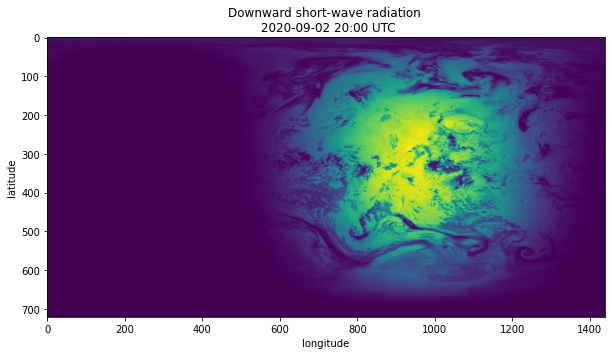

In [43]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.imshow(radiation)
plt.title('Downward short-wave radiation \n 2020-09-02 20:00 UTC')
ax.set(xlabel='longitude', ylabel='latitude')

We can try to parse this using a `pandas.DataFrame`. We can apply different functions or slicing by changing the shape of our `DataFrame`. 

In [44]:
radiation_df = pd.DataFrame(radiation,
                            index=np.arange(-90, 90.25, 0.25),
                            columns=np.arange(-180, 180, 0.25))
radiation_df

,-180.00,-179.75,-179.50,-179.25,-179.00,-178.75,-178.50,-178.25,-178.00,-177.75,-177.50,-177.25,-177.00,-176.75,-176.50,-176.25,-176.00,-175.75,-175.50,-175.25,-175.00,-174.75,-174.50,-174.25,-174.00,-173.75,-173.50,-173.25,-173.00,-172.75,-172.50,-172.25,-172.00,-171.75,-171.50,-171.25,-171.00,-170.75,-170.50,-170.25,...,170.00,170.25,170.50,170.75,171.00,171.25,171.50,171.75,172.00,172.25,172.50,172.75,173.00,173.25,173.50,173.75,174.00,174.25,174.50,174.75,175.00,175.25,175.50,175.75,176.00,176.25,176.50,176.75,177.00,177.25,177.50,177.75,178.00,178.25,178.50,178.75,179.00,179.25,179.50,179.75
-90.00,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,...,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0
-89.75,56.0,56.0,56.0,56.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,...,55.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0
-89.50,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,47.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0
-89.25,42.0,42.0,42.0,42.0,42.0,42.0,42.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,...,40.0,40.0,40.0,40.0,40.0,40.0,40.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0
-89.00,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,42.0,42.0,42.0,42.0,42.0,42.0,...,36.0,36.0,36.0,36.0,36.0,36.0,36.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,39.0,39.0,39.0,39.0,39.0,39.0,39.0,39.0,39.0,40.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89.75,0.0,0.0,0.0,0.0,

But imagine having several variables or multiple days?! Complicated! One option to have several observation is transforming the above `DataFrame` to a long format, but this option is not always the most practical one, particularly if grids are more granular.

In [45]:
radiation_df_long = radiation_df.unstack()
radiation_df_long

-180.00  -90.00    61.0
         -89.75    56.0
         -89.50    48.0
         -89.25    42.0
         -89.00    40.0
                   ... 
 179.75   89.00     0.0
          89.25     0.0
          89.50     0.0
          89.75     0.0
          90.00     0.0
Length: 1038240, dtype: float64

Having the data in the long-format allow us to use `split-apply-combine` operations, but we lost the abilities of running vectorized operation in one call. That's why `xarray` is so powerful, we can have both of best worlds, and even more. 

## 2. Data structures in `xarray`

In `xarray` we can have several nd-array variables, like temperature or precipitation in the same grid (sharing the same dimensions) while keeping an array shape.

Datasets (storage model) have the following components:

  - Dimensions (`dims`)  - record shape of the data (number of time points, number of latitudinal grid cells)
  - Coordinates (`coords`) - list of coordinates, time points, longitudes and latitudes
  - Data variables (`data_vars`) - hold data values, the shape is specified with a list of dimensions
  - Attributes (`attrs`) - describe the variables (units)
  
  - Global attributes apply to the entire file - authors, provenance etc.


 ![](http://xarray.pydata.org/en/stable/_images/dataset-diagram.png)

## Section 2 - Data structures

Similar to `pandas` we have two basic data structures: `DataArray` and `DataSet`. Think of these as multi-dimensional generalizations of a `pd.Series` and a `pd.DataFrame`, respectively. 

### 2.1. `DataArrays`

A `DataArray` contains only one array indexed by several coordinates. 

In [46]:
radiation_ar = xr.DataArray(np.expand_dims(radiation, 0),
                            coords=[pd.date_range("2020-09-02 20:00", periods=1),
                                    np.arange(-90, 90.25, 0.25),
                                    np.arange(-180, 180, 0.25)],
                             dims=['time', 'latitude', 'longitude'])
radiation_ar

<xarray.DataArray (time: 1, latitude: 721, longitude: 1440)>
array([[[61., 61., 61., ..., 61., 61., 61.],
        [56., 56., 56., ..., 56., 56., 56.],
        [48., 48., 48., ..., 48., 48., 48.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]])
Coordinates:
  * time       (time) datetime64[ns] 2020-09-02T20:00:00
  * latitude   (latitude) float64 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * longitude  (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8

Just as any `np.array` we can index using our square brackets and selecting by index location

In [ ]:
radiation_ar[0, 0, 0]

<xarray.DataArray ()>
array(61.)
Coordinates:
    time       datetime64[ns] 2020-09-02T10:00:00
    latitude   float64 -90.0
    longitude  float64 -180.0

But we have ~better~ more powerful options. Just as a `pd.Series` you can slice data in multiple ways using axis or `boolean` options. You can select by any of the `coords` values using `sel`, or picking by the order of the coordinate of interest using `isel`

In [49]:
radiation_ar.sel(latitude=0)

<xarray.DataArray (time: 1, longitude: 1440)>
array([[0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time       (time) datetime64[ns] 2020-09-02T20:00:00
    latitude   float64 0.0
  * longitude  (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8

In [50]:
radiation_ar.isel(latitude=(720//2))

<xarray.DataArray (time: 1, longitude: 1440)>
array([[0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time       (time) datetime64[ns] 2020-09-02T20:00:00
    latitude   float64 0.0
  * longitude  (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8

We can also take a slice of values, just as we learnt in `pandas`. Although, here, we can use the `slice` object to get the range of elements we need

In [51]:
radiation_ar.sel(latitude=slice(-90, 0))

<xarray.DataArray (time: 1, latitude: 361, longitude: 1440)>
array([[[61., 61., 61., ..., 61., 61., 61.],
        [56., 56., 56., ..., 56., 56., 56.],
        [48., 48., 48., ..., 48., 48., 48.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]])
Coordinates:
  * time       (time) datetime64[ns] 2020-09-02T20:00:00
  * latitude   (latitude) float64 -90.0 -89.75 -89.5 -89.25 ... -0.5 -0.25 0.0
  * longitude  (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8

Slicing is not limited to this literal evaluation, we can also use a `dict` for a more programatic approach into slicing: 

In [52]:
radiation_ar.sel({'latitude': slice(0, 90)})

<xarray.DataArray (time: 1, latitude: 361, longitude: 1440)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * time       (time) datetime64[ns] 2020-09-02T20:00:00
  * latitude   (latitude) float64 0.0 0.25 0.5 0.75 ... 89.25 89.5 89.75 90.0
  * longitude  (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8

Most of the times, and this is especially truth with gridded data, we need to index by values that are within the range of our coordinate of interest, but without an exact match. 

For instance, what's the downward radiation value in Beijing? 

In [55]:
radiation_ar.sel({'latitude': 39.9042,
                 'longitude': 116.4074},
                 method='nearest')

<xarray.DataArray (time: 1)>
array([153.])
Coordinates:
  * time       (time) datetime64[ns] 2020-09-02T20:00:00
    latitude   float64 40.0
    longitude  float64 116.5

#### Check-in [# 0]

What happens if you take a slice between the latitude 45 and 90 using the `nearest` method? 

In [56]:
"""
Use this chunk to answer your question!
"""

radiation_ar.sel(latitude=slice(40, 90),
                 method='nearest')

NotImplementedError: ignored

### 2.2. Some advanced indexing

`xarray` has some built boolean slicing functionalities that are pretty close to `numpy` and `pandas` masking.

In [57]:
radiation_ar.where(radiation_ar > 0)

<xarray.DataArray (time: 1, latitude: 721, longitude: 1440)>
array([[[61., 61., 61., ..., 61., 61., 61.],
        [56., 56., 56., ..., 56., 56., 56.],
        [48., 48., 48., ..., 48., 48., 48.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2020-09-02T20:00:00
  * latitude   (latitude) float64 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * longitude  (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8

Following Amanda's mantra and only to show some of the *coolest* features that `xarray` has to offer, let's plot this!

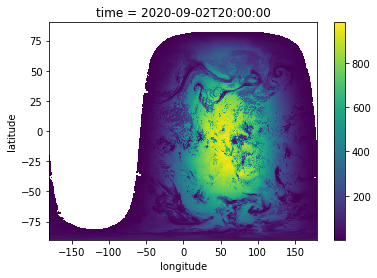

In [58]:
radiation_ar.where(radiation_ar > 0).plot()

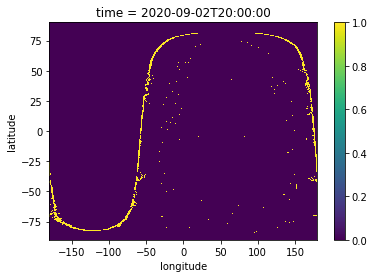

In [59]:
radiation_ar.isin([1, 100]).plot()

#### Check-in [# 1]

Plot the downward radiation where the values are equal to Beijing value (calculated in the previous section) 

[153.]


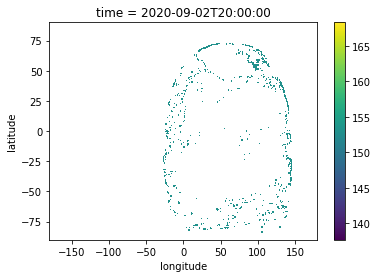

In [63]:
"""
Code your answer to the check-in here
"""

beijing_radiation = radiation_ar.sel({'latitude': 39.9042,
                 'longitude': 116.4074},
                 method='nearest').values

print(beijing_radiation)

radiation_ar.where(radiation_ar == beijing_radiation).plot()

### 2.3. Datasets

`Datasets` have all the functionality from an `DataArray`, but we can hold several arrays with equal indexing. To illustrate this we are going to cheat a little bit and start with our first real-world example. 

Here we have ERA-5 reanalysis data. This data product processed by the European NOAA constains a myriad of different weather variables that are compiled around the world and then smoothed in time and space using fancy climate models. This file is a NetCDF file (`nc4`), one of the most widely use formats in climate science and allow us to store several arrays with identical axis in a efficient way. 

In [65]:
xr_era = xr.open_dataset(os.path.join(loaddir, 'era_5_example.nc4'))
xr_era

<xarray.Dataset>
Dimensions:    (latitude: 73, longitude: 144, time: 124)
Coordinates:
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * time       (time) datetime64[ns] 2015-07-01 ... 2015-07-31T18:00:00
Data variables:
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    z          (time, latitude, longitude) float32 ...
    cape       (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
    lsm        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-09-01 14:10:32 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

As you can see above the structure is pretty similar to what we have seen before, but we have additional values: `d2m`, `t2m`, etc. 

Slicing is identical to the `DataArrays`, but we can select data using either the "point" accesor or the squared brackets `ds['var']`

In [66]:
xr_era.t2m.isel(time=0)

<xarray.DataArray 't2m' (latitude: 73, longitude: 144)>
array([[274.11237, 274.11237, 274.11237, ..., 274.11237, 274.11237, 274.11237],
       [274.1222 , 274.13986, 274.1536 , ..., 274.132  , 274.16537, 274.14575],
       [274.17914, 274.35196, 274.34412, ..., 274.0122 , 274.0927 , 274.16736],
       ...,
       [213.406  , 212.76968, 212.3003 , ..., 216.91759, 215.50943, 214.36246],
       [214.93791, 215.04199, 215.14412, ..., 214.61975, 214.5078 , 214.74936],
       [209.65482, 209.65482, 209.65482, ..., 209.65482, 209.65482, 209.65482]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
    time       datetime64[ns] 2015-07-01
Attributes:
    units:      K
    long_name:  2 metre temperature

We can have access to the underlying array by using the `values` method

In [67]:
xr_era.t2m.sel(time='2015-07-01').values

array([[[274.11237, 274.11237, 274.11237, ..., 274.11237, 274.11237,
         274.11237],
        [274.1222 , 274.13986, 274.1536 , ..., 274.132  , 274.16537,
         274.14575],
        [274.17914, 274.35196, 274.34412, ..., 274.0122 , 274.0927 ,
         274.16736],
        ...,
        [213.406  , 212.76968, 212.3003 , ..., 216.91759, 215.50943,
         214.36246],
        [214.93791, 215.04199, 215.14412, ..., 214.61975, 214.5078 ,
         214.74936],
        [209.65482, 209.65482, 209.65482, ..., 209.65482, 209.65482,
         209.65482]],

       [[274.20465, 274.20465, 274.20465, ..., 274.20465, 274.20465,
         274.20465],
        [274.022  , 274.077  , 274.13397, ..., 274.0161 , 274.0181 ,
         274.022  ],
        [273.91794, 273.89044, 273.87274, ..., 273.88846, 273.8708 ,
         273.8983 ],
        ...,
        [212.25119, 211.46364, 210.84892, ..., 215.82169, 214.44102,
         213.25674],
        [213.3196 , 212.8561 , 212.38474, ..., 213.71239, 213.52974,
   

And this is also valid for any of the coordinates:

In [68]:
xr_era.time.values[0:10]

array(['2015-07-01T00:00:00.000000000', '2015-07-01T06:00:00.000000000',
       '2015-07-01T12:00:00.000000000', '2015-07-01T18:00:00.000000000',
       '2015-07-02T00:00:00.000000000', '2015-07-02T06:00:00.000000000',
       '2015-07-02T12:00:00.000000000', '2015-07-02T18:00:00.000000000',
       '2015-07-03T00:00:00.000000000', '2015-07-03T06:00:00.000000000'],
      dtype='datetime64[ns]')

#### Check-in [# 2]

Slice the `xr_era` objects and get all the values corresponding to the surface temeprature (`t2m`) between `2015-07-01` and `2015-07-10`. 

In [70]:
"""
Use this chunk to answer the question
"""

xr_era['t2m'].sel(time=slice('2015-07-01', '2015-07-10'))

<xarray.DataArray 't2m' (time: 40, latitude: 73, longitude: 144)>
[420480 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * time       (time) datetime64[ns] 2015-07-01 ... 2015-07-10T18:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

## Section 3 - Computation

Just as `pandas` and `numpy` we have varied options to play around with our `DataArrays` and `Datasets`. In this section we will cover several calculations ranging from simple array arithmetic to `groupby` operations. 


### 3.1. Arithmetic operations

Let's use our `Dataset`, `xr_era` to calculate wet-bulb temperature, the lowest temperature to which air can be cooled by the evaporation of water into the air at a constant pressure. Intuitively is a measure of air moisture.  

To calcualte it we can use the one-third rule:

$$
T_{w} = T-\frac{1}{3}(T-T_{d})
$$

where $T$ is our `t2m`, and $T_{d}$ is our dew-point temperature (`d2m`)


In [ ]:
xr_era

<xarray.Dataset>
Dimensions:    (latitude: 73, longitude: 144, time: 124)
Coordinates:
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * time       (time) datetime64[ns] 2015-07-01 ... 2015-07-31T18:00:00
Data variables:
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    z          (time, latitude, longitude) float32 ...
    cape       (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
    lsm        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-09-01 14:10:32 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

In [74]:
xr_era.t2m - (1/3) * (xr_era.t2m - xr_era.d2m)

<xarray.DataArray (time: 124, latitude: 73, longitude: 144)>
array([[[273.8626 , 273.8626 , 273.8626 , ..., 273.8626 , 273.8626 ,
         273.8626 ],
        [274.01166, 274.0269 , 274.04004, ..., 274.0056 , 274.02957,
         274.02222],
        [274.0708 , 274.2049 , 274.2008 , ..., 273.85764, 273.96167,
         274.04578],
        ...,
        [212.01994, 211.57227, 211.24332, ..., 215.36255, 213.96422,
         212.85103],
        [213.42982, 213.53412, 213.63539, ..., 213.10211, 213.     ,
         213.24059],
        [208.08609, 208.08609, 208.08609, ..., 208.08609, 208.08609,
         208.08609]],

       [[274.02255, 274.02255, 274.02255, ..., 274.02255, 274.02255,
         274.02255],
        [273.91168, 273.9489 , 273.98117, ..., 273.8362 , 273.8759 ,
         273.8962 ],
        [273.67517, 273.7078 , 273.7349 , ..., 273.73337, 273.70898,
         273.72388],
        ...,
        [211.00798, 210.34102, 209.77211, ..., 214.3475 , 212.97093,
         211.83002],
        [211.99153, 211.52342, 211.04436, ..., 212.39189, 212.21461,
         212.10982],
        [208.47601, 208.47601, 208.47601, ..., 208.47601, 208.47601,
         208.47601]],

       [[273.87137, 273.87137, 273.87137, ..., 273.87137, 273.87137,
         273.87137],
        [273.91385, 273.91882, 273.9139 , ..., 273.8948 , 273.91238,
         273.91513],
        [273.8679 , 273.84198, 273.7759 , ..., 274.0525 , 274.04184,
         274.0253 ],
        ...,
        [209.39153, 208.96628, 208.66739, ..., 212.31929, 211.08269,
         210.10742],
        [211.0479 , 210.80534, 210.59927, ..., 211.09364, 210.95145,
         211.02122],
        [210.27591, 210.27591, 210.27591, ..., 210.27591, 210.27591,
         210.27591]],

       ...,

       [[273.70306, 273.70306, 273.70306, ..., 273.70306, 273.70306,
         273.70306],
        [273.6717 , 273.70013, 273.7327 , ..., 273.6222 , 273.64288,
         273.6491 ],
        [273.60672, 273.6973 , 273.80142, ..., 273.26062, 273.44904,
         273.54736],
        ...,
        [213.34216, 213.19975, 213.12688, ..., 215.19048, 214.34859,
         213.67445],
        [219.73161, 219.4241 , 219.17084, ..., 220.90941, 220.34288,
         220.05598],
        [222.75241, 222.75241, 222.75241, ..., 222.75241, 222.75241,
         222.75241]],

       [[273.83133, 273.83133, 273.83133, ..., 273.83133, 273.83133,
         273.83133],
        [273.78647, 273.8021 , 273.8166 , ..., 273.78296, 273.78183,
         273.78003],
        [273.155  , 273.53204, 273.8495 , ..., 273.3246 , 273.17862,
         273.13724],
        ...,
        [216.58136, 216.22966, 215.91624, ..., 218.74057, 217.84265,
         217.10663],
        [223.12999, 222.65543, 222.25146, ..., 225.05016, 224.32272,
         223.74141],
        [225.08096, 225.08096, 225.08096, ..., 225.08096, 225.08096,
         225.08096]],

       [[273.69785, 273.69785, 273.69785, ..., 273.69785, 273.69785,
         273.69785],
        [273.32794, 273.40204, 273.4837 , ..., 273.18256, 273.2332 ,
         273.2737 ],
        [273.32352, 273.35385, 273.32687, ..., 273.3127 , 273.25357,
         273.30594],
        ...,
        [218.0004 , 217.06485, 216.30656, ..., 221.7106 , 220.45518,
         219.16647],
        [226.67934, 226.16765, 225.71034, ..., 228.51524, 227.85826,
         227.26917],
        [227.79288, 227.79288, 227.79288, ..., 227.79288, 227.79288,
         227.79288]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * time       (time) datetime64[ns] 2015-07-01 ... 2015-07-31T18:00:00

We can assign this to a new variable inside our `Dataset`

In [75]:
xr_era['wbulb'] = xr_era.t2m - (1/3) * (xr_era.t2m - xr_era.d2m)
xr_era

<xarray.Dataset>
Dimensions:    (latitude: 73, longitude: 144, time: 124)
Coordinates:
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * time       (time) datetime64[ns] 2015-07-01 ... 2015-07-31T18:00:00
Data variables:
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 274.11237 ... 229.06279
    sp         (time, latitude, longitude) float32 ...
    z          (time, latitude, longitude) float32 ...
    cape       (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
    lsm        (time, latitude, longitude) float32 ...
    wbulb      (time, latitude, longitude) float32 273.8626 ... 227.79288
Attributes:
    Conventions:  CF-1.6
    history:      2019-09-01 14:10:32 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

### 3.2. Aggregations

We can use our coordinates to aggregate variables: `mean`, `sum`, `min`, `max`, etc.

For instance, we can calculate the mean temperature across all the elements of the `time` coordinate.

In [76]:
xr_era.t2m.mean(dim='time')

<xarray.DataArray 't2m' (latitude: 73, longitude: 144)>
array([[273.98145, 273.98145, 273.98145, ..., 273.98145, 273.98145,
        273.98145],
       [273.95615, 273.96603, 273.97437, ..., 273.96082, 273.98795,
        273.97174],
       [273.87067, 273.91916, 273.89365, ..., 273.85477, 273.8557 ,
        273.86023],
       ...,
       [215.80434, 215.03421, 214.40474, ..., 218.93665, 217.86154,
        216.79579],
       [216.66002, 216.51822, 216.41585, ..., 216.93727, 216.7438 ,
        216.728  ],
       [214.98872, 214.98872, 214.98872, ..., 214.98872, 214.98872,
        214.98872]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0

In [ ]:
xr_era.tp.sum(dim=['latitude', 'time'])

<xarray.DataArray 'tp' (longitude: 144)>
array([0.4754375 , 0.4651175 , 0.4937202 , 0.5322569 , 0.54300237,
       0.5219128 , 0.5026412 , 0.48719087, 0.528877  , 0.4912506 ,
       0.5257316 , 0.54182404, 0.5639297 , 0.5946121 , 0.5918456 ,
       0.69927365, 0.5029975 , 0.5027132 , 0.5089156 , 0.5408871 ,
       0.5883584 , 0.5619938 , 0.6119943 , 0.6703233 , 0.58022106,
       0.64006543, 0.6769335 , 0.8064908 , 1.0619636 , 1.1973809 ,
       1.2131245 , 0.9861129 , 1.0598565 , 0.96380454, 1.1047293 ,
       1.3112578 , 1.4603868 , 1.569258  , 1.420336  , 1.470105  ,
       1.0839043 , 1.1498207 , 1.0297424 , 1.0431143 , 0.964662  ,
       0.9101148 , 1.0987307 , 1.1929643 , 1.2728955 , 1.0213147 ,
       1.0449723 , 1.2670459 , 1.2561233 , 1.0631077 , 1.2157958 ,
       1.3273528 , 1.4127164 , 1.1540309 , 1.0558752 , 1.0320292 ,
       1.0464425 , 1.149092  , 1.2652469 , 1.3512177 , 1.3519832 ,
       1.356525  , 1.2915195 , 1.3294256 , 1.1753358 , 1.0762104 ,
       1.0777633 , 1.0467011 , 1.0280559 , 1.0142732 , 1.0228993 ,
       1.0092641 , 0.9630361 , 0.9576484 , 1.024287  , 1.0019749 ,
       1.0050219 , 0.96408117, 1.0553246 , 1.0768708 , 1.0613341 ,
       1.0028057 , 1.0001426 , 0.9841617 , 0.9725397 , 0.9520983 ,
       1.0165381 , 1.0633643 , 1.0552946 , 1.0318366 , 1.0629693 ,
       1.0968591 , 1.0667837 , 0.99869764, 1.0398182 , 0.9578601 ,
       0.94365376, 1.0609207 , 1.1181186 , 1.0056355 , 1.051317  ,
       0.97516733, 0.9481889 , 0.8858741 , 0.8828368 , 0.903125  ,
       0.92243433, 0.8332693 , 0.85253394, 1.3146119 , 1.1383148 ,
       1.3730602 , 1.0113126 , 0.88984156, 0.95775217, 0.887402  ,
       0.7689101 , 0.8197226 , 0.8277395 , 0.8364076 , 0.7587411 ,
       0.728739  , 0.7352368 , 0.7643744 , 0.8640117 , 0.8641342 ,
       0.8328141 , 0.7692029 , 0.77219564, 0.8001816 , 0.7252334 ,
       0.7809491 , 0.7016645 , 0.74975324, 0.791883  , 0.65617853,
       0.61275977, 0.53035074, 0.50336015, 0.48753944], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5

Or even the mean for the whole space:

In [77]:
xr_era.t2m.mean() - 273.15

<xarray.DataArray 't2m' ()>
array(7.39174805)

### 3.3. Window calculations

Despite having a powerful slicing, sometime we want to aggregate across different time and space windows. For instance, let us calculate the mean surface temperature for each latitude across all times and longitudes. 

We can solve this with a simple loop, but is not a good approach and makes difficult to add dimensions to our aggregation window. 

In [78]:
mean_lst = np.array([])
for i in range(-90, 90, 10): 
    m = xr_era.t2m.sel(latitude=slice(i+10, i)).mean()
    mean_lst = np.append(m.values, mean_lst)

print(mean_lst)

[274.01745605 276.29611206 283.77850342 287.26977539 292.10354614
 296.92730713 300.55245972 300.85287476 299.63378906 298.75369263
 296.03518677 291.5826416  286.94900513 280.9588623  274.20480347
 259.69134521 235.86027527 222.79804993]


Here we can use `coarsen()` to solve this calculation problem. We want to create a window that contains 10 latitudes. For this, we can coarsen our array by 4 to obtain 18 windows (`73//4`)

In [ ]:
xr_era.t2m.coarsen(latitude=4, 
                   longitude=144,
                   time=124,
                   boundary='pad').mean()

Wow, this was confusing, let us plot this and check what are the differences. In the first plot we have our raw data at the native resolution. 

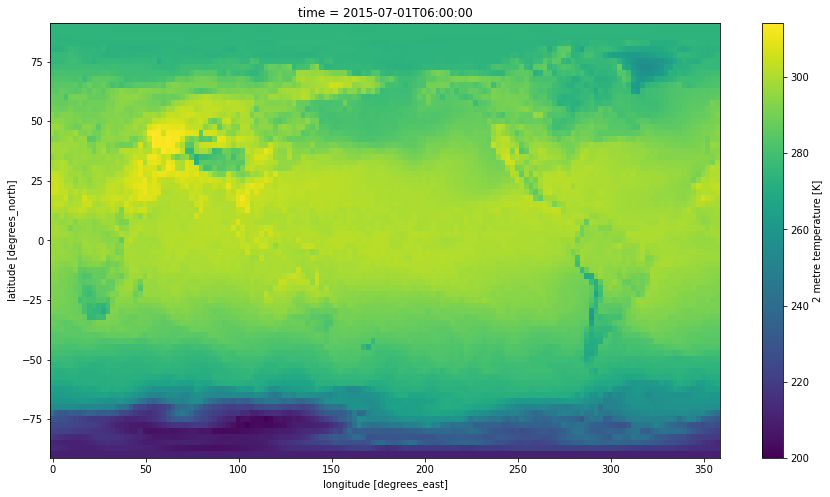

In [80]:
fig, ax = plt.subplots(figsize=(15, 8))
xr_era.t2m.isel(time=1).plot()

Now, when we `coarse` our data, we see a lower resolution image that shows the local mean calculation across a window of 2-times the size of the original resolution. 

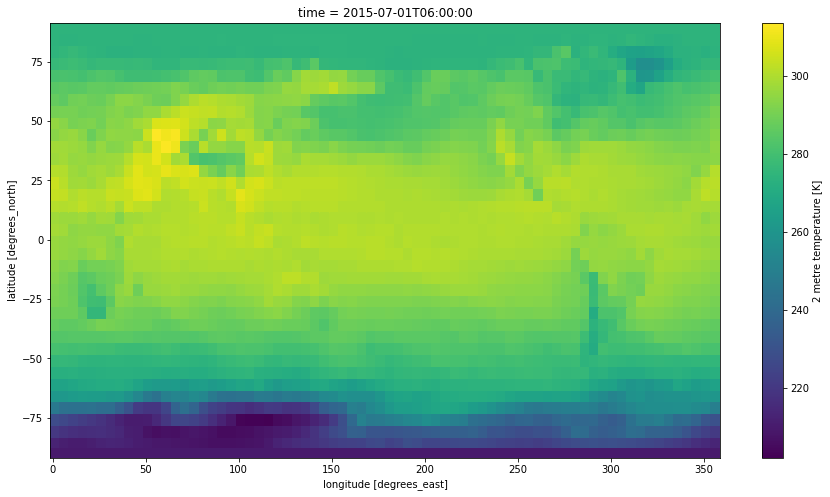

In [81]:
fig, ax = plt.subplots(figsize=(15, 8))
xr_era.t2m.coarsen(latitude=2, longitude=2, boundary='pad').mean().isel(time=1).plot()

#### Check-in [# 3]

`coarsen()` the gridded surface temeprature by a factor of 4 and calculate the means for each of the `times`.

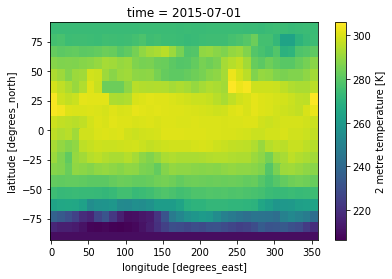

In [86]:
"""
Use this block to answer the question
"""

xr_era.t2m.coarsen(latitude=4, longitude=4, boundary='pad').mean().isel(time=0).plot()

### 3.4 Time resampling

Although we can use windows in time, it's hard to make exact time windows with `coarsen` and its functionality is limited to a size factor. We can use the power of `resample()` to create time windows and execute calculations in them. These windows are not depending on the time units (i.e. if I have hourly data, I can resample to the week data). 

In [87]:
xr_era.t2m.resample(time='1W').mean()

<xarray.DataArray 't2m' (time: 5, latitude: 73, longitude: 144)>
array([[[274.20035, 274.20035, 274.20035, ..., 274.20035, 274.20035,
         274.20035],
        [274.21457, 274.21054, 274.20377, ..., 274.24692, 274.25925,
         274.2356 ],
        [274.15173, 274.20648, 274.18726, ..., 274.1358 , 274.13898,
         274.1489 ],
        ...,
        [213.38057, 212.69955, 212.09143, ..., 216.44064, 215.374  ,
         214.34665],
        [212.58548, 212.6066 , 212.67236, ..., 212.05154, 212.10202,
         212.37756],
        [207.19478, 207.19478, 207.19478, ..., 207.19478, 207.19478,
         207.19478]],

       [[274.0204 , 274.0204 , 274.0204 , ..., 274.0204 , 274.0204 ,
         274.0204 ],
        [273.70554, 273.7175 , 273.72482, ..., 273.6796 , 273.73785,
         273.72406],
        [273.54715, 273.5978 , 273.58182, ..., 273.56168, 273.57745,
         273.5449 ],
        ...,
        [214.43375, 213.78352, 213.23943, ..., 217.02547, 216.14835,
         215.27527],
        [213.189  , 213.08266, 213.00462, ..., 213.23972, 213.13728,
         213.18808],
        [208.61107, 208.61107, 208.61107, ..., 208.61107, 208.61107,
         208.61107]],

       [[273.95   , 273.95   , 273.95   , ..., 273.95   , 273.95   ,
         273.95   ],
        [274.15756, 274.16403, 274.16913, ..., 274.18665, 274.21695,
         274.18927],
        [274.03915, 274.07904, 274.01666, ..., 274.06955, 274.03723,
         274.0345 ],
        ...,
        [215.55836, 214.50197, 213.63449, ..., 219.2792 , 218.05403,
         216.78499],
        [217.93352, 217.70163, 217.52727, ..., 218.58713, 218.25606,
         218.12479],
        [218.86809, 218.86809, 218.86809, ..., 218.86809, 218.86809,
         218.86809]],

       [[273.88358, 273.88358, 273.88358, ..., 273.88358, 273.88358,
         273.88358],
        [273.89963, 273.90854, 273.91635, ..., 273.9057 , 273.9179 ,
         273.90717],
        [273.92734, 273.94656, 273.8996 , ..., 273.88385, 273.8846 ,
         273.90628],
        ...,
        [218.04492, 217.13048, 216.33824, ..., 221.6572 , 220.42195,
         219.18459],
        [219.0785 , 218.9334 , 218.82089, ..., 219.34367, 219.15321,
         219.14183],
        [218.63551, 218.63551, 218.63551, ..., 218.63551, 218.63551,
         218.63551]],

       [[273.88885, 273.88885, 273.88885, ..., 273.88885, 273.88885,
         273.88885],
        [273.84586, 273.87308, 273.9032 , ..., 273.82956, 273.84387,
         273.84036],
        [273.72723, 273.82013, 273.85626, ..., 273.64294, 273.6677 ,
         273.70444],
        ...,
        [217.35428, 216.93008, 216.72063, ..., 219.82022, 218.89355,
         218.04414],
        [220.42522, 220.20163, 220.01184, ..., 221.32101, 220.94441,
         220.69962],
        [221.17468, 221.17468, 221.17468, ..., 221.17468, 221.17468,
         221.17468]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2015-07-05 2015-07-12 ... 2015-08-02
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0

You can pass to `resample()` any available `timedelta` available in the `pandas` library. For instance: 
 - `time.hour`: to the hour level
 - `nM`: to a n number of months
 - `nY`: to a n number of years

 You can also apply different functions using `reduce`: 

In [88]:
xr_era.t2m.resample(time='1d').reduce(np.median)

<xarray.DataArray 't2m' (time: 31, latitude: 73, longitude: 144)>
array([[[274.15265, 274.15265, 274.15265, ..., 274.15265, 274.15265,
         274.15265],
        [274.09863, 274.10843, 274.13104, ..., 274.10254, 274.12512,
         274.1114 ],
        [274.133  , 274.20956, 274.16638, ..., 274.2312 , 274.27142,
         274.27734],
        ...,
        [211.48524, 210.80472, 210.30196, ..., 214.83578, 213.52188,
         212.42108],
        [212.86298, 212.51239, 212.17754, ..., 213.08295, 212.91501,
         212.9042 ],
        [210.74875, 210.74875, 210.74875, ..., 210.74875, 210.74875,
         210.74875]],

       [[274.242  , 274.242  , 274.242  , ..., 274.242  , 274.242  ,
         274.242  ],
        [274.1703 , 274.15063, 274.16147, ..., 274.3117 , 274.2852 ,
         274.22922],
        [274.19684, 274.21448, 274.18207, ..., 274.23804, 274.2096 ,
         274.18994],
        ...,
        [210.61815, 209.74222, 209.13043, ..., 215.89337, 213.86166,
         212.04596],
        [212.6489 , 212.5016 , 212.43974, ..., 212.37787, 212.37296,
         212.56052],
        [209.22961, 209.22961, 209.22961, ..., 209.22961, 209.22961,
         209.22961]],

       [[274.239  , 274.239  , 274.239  , ..., 274.239  , 274.239  ,
         274.239  ],
        [274.31268, 274.33234, 274.31955, ..., 274.33234, 274.34116,
         274.3284 ],
        [274.10547, 274.2135 , 274.24298, ..., 273.9248 , 273.94247,
         274.04852],
        ...,
        [212.11667, 211.40767, 210.74286, ..., 216.133  , 214.59912,
         213.20961],
        [212.2453 , 212.37198, 212.59488, ..., 211.74252, 211.6669 ,
         212.01944],
        [205.36157, 205.36157, 205.36157, ..., 205.36157, 205.36157,
         205.36157]],

       ...,

       [[273.9837 , 273.9837 , 273.9837 , ..., 273.9837 , 273.9837 ,
         273.9837 ],
        [274.0564 , 274.05048, 274.04657, ..., 274.0338 , 274.0436 ,
         274.02887],
        [273.71368, 273.8011 , 273.78534, ..., 273.71075, 273.6479 ,
         273.67242],
        ...,
        [213.74185, 214.16705, 214.81221, ..., 214.73071, 214.17099,
         213.8322 ],
        [215.38078, 215.35428, 215.35327, ..., 215.50943, 215.39453,
         215.39847],
        [214.72777, 214.72777, 214.72777, ..., 214.72777, 214.72777,
         214.72777]],

       [[274.11923, 274.11923, 274.11923, ..., 274.11923, 274.11923,
         274.11923],
        [273.92578, 273.95328, 273.9837 , ..., 273.9248 , 273.93463,
         273.92578],
        [274.00238, 274.08093, 274.08682, ..., 273.87766, 273.9729 ,
         274.01907],
        ...,
        [215.05966, 214.99878, 215.17358, ..., 217.56963, 216.59746,
         215.69305],
        [218.09204, 217.7788 , 217.49304, ..., 219.23114, 218.74507,
         218.43771],
        [218.57617, 218.57617, 218.57617, ..., 218.57617, 218.57617,
         218.57617]],

       [[273.87177, 273.87177, 273.87177, ..., 273.87177, 273.87177,
         273.87177],
        [273.73334, 273.75787, 273.7824 , ..., 273.69696, 273.71954,
         273.7225 ],
        [273.4878 , 273.64   , 273.85803, ..., 273.33463, 273.39648,
         273.46228],
        ...,
        [216.3559 , 216.04755, 215.79518, ..., 218.44556, 217.56865,
         216.84198],
        [222.8046 , 222.42062, 222.09854, ..., 224.34042, 223.69919,
         223.26907],
        [225.21439, 225.21439, 225.21439, ..., 225.21439, 225.21439,
         225.21439]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2015-07-01 2015-07-02 ... 2015-07-31
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0

Upsampling is also available using the [interpolation methods][1]. Here we wont cover those. 

[1]: http://xarray.pydata.org/en/stable/interpolation.html#interpolation-methods

### 3.5 `split-apply-combine`

We have covered different ways of aggregating our data. Why bother with `groupby`? Well, despite having covered some aggregations, these are very much restrain to the already built methods. With `groupby` we have more control over the functions we apply to each of our chunks, and also give us more functionality for other operations. 

Just as `pandas`, the operation consists of dividing one data set by a specific key, or set of keys, apply a function to each of them, and return a new aggregated data set.  

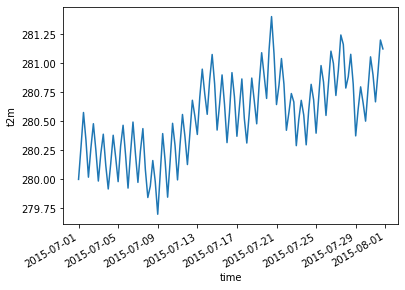

In [89]:
def standardize(x):
    return (x - x.mean()) / x.std()

xr_era.t2m.groupby('time').mean(...).plot()

Notice that we can arrive to this same result using what we learnt in the past sections. Aggregations are also `split-apply-combine` operations.

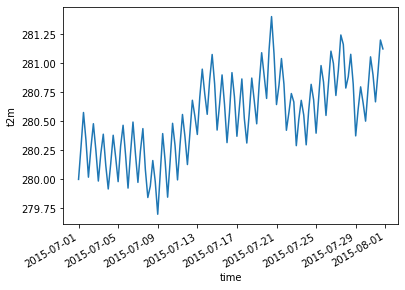

In [91]:
xr_era.t2m.mean(dim=['latitude', 'longitude']).plot()

#### Check-in [# 4]

Try now yourself to calculate the mean temperature surface for each `latitude` band across `time`. 

_Hint_: 

1. `groupby` latitude
2. `mean`
3. `.plot(y='latitude)`

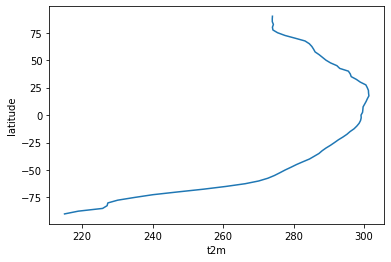

In [96]:
"""
Use this code block to answer your question
"""

xr_era.t2m.groupby('latitude').mean(...).plot(y='latitude')

Another nice use of grouping operations is the ability to run operations using specific slices of data. One common data processing operation is demeaning, or the calculation of anomalies. We covered that on the `pandas` session, as a row operation, but we can do it here with more complex means.

Let us demean our data using only the means of each day of week (i.e. Sunday is the day 0, Monday is the day 1, and so on).

In [97]:
hour_mean = xr_era.t2m.groupby('time.dayofweek').mean()
demean_t2m = xr_era.t2m.groupby('time.dayofweek') - hour_mean

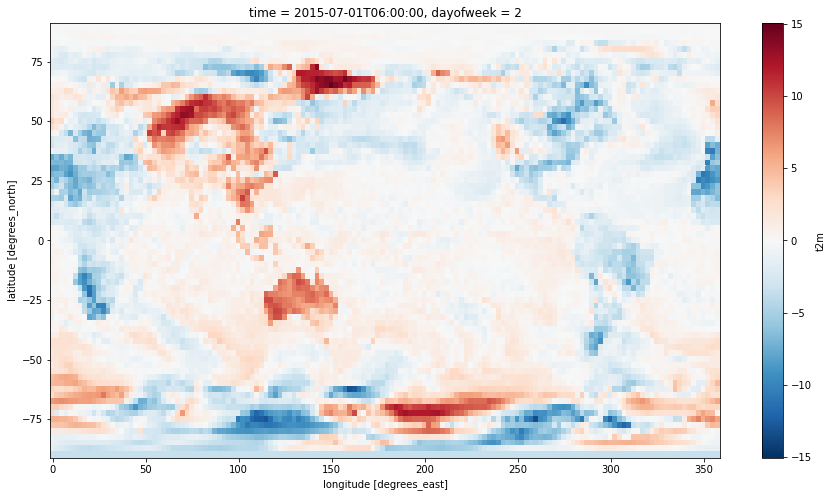

In [98]:
fig, ax = plt.subplots(figsize=(15, 8))
demean_t2m.isel(time=1).plot()

We can also write our own functions! 

In [99]:
def standardize(x):
    return (x - x.mean()) / x.std()

std_t2m = xr_era.t2m.groupby('time').map(standardize)
std_t2m

<xarray.DataArray 't2m' (time: 124, latitude: 73, longitude: 144)>
array([[[-0.25197722, -0.25197722, -0.25197722, ..., -0.25197722,
         -0.25197722, -0.25197722],
        [-0.25155645, -0.25079985, -0.25021181, ..., -0.25113699,
         -0.24970741, -0.25054765],
        [-0.24911807, -0.24171801, -0.24205384, ..., -0.25626594,
         -0.25281876, -0.24962247],
        ...,
        [-2.85137687, -2.87862369, -2.89872265, ..., -2.70101365,
         -2.76130987, -2.81042236],
        [-2.78578183, -2.78132519, -2.77695219, ..., -2.79940524,
         -2.80419901, -2.79385552],
        [-3.01199995, -3.01199995, -3.01199995, ..., -3.01199995,
         -3.01199995, -3.01199995]],

       [[-0.25770178, -0.25770178, -0.25770178, ..., -0.25770178,
         -0.25770178, -0.25770178],
        [-0.26545171, -0.26311832, -0.26070075, ..., -0.26570163,
         -0.26561746, -0.26545171],
        [-0.2698673 , -0.27103399, -0.27178503, ..., -0.27111816,
         -0.27186791, -0.27070121],
        ...,
        [-2.88645183, -2.91986848, -2.9459515 , ..., -2.73495197,
         -2.79353486, -2.84378511],
        [-2.84111828, -2.86078511, -2.88078538, ..., -2.82445172,
         -2.83220165, -2.8362851 ],
        [-2.98986844, -2.98986844, -2.98986844, ..., -2.98986844,
         -2.98986844, -2.98986844]],

       [[-0.27059446, -0.27059446, -0.27059446, ..., -0.27059446,
         -0.27059446, -0.27059446],
        [-0.27282109, -0.27348088, -0.27422267, ..., -0.27290309,
         -0.27240857, -0.2727391 ],
        [-0.27232657, -0.27298636, -0.27455192, ..., -0.25154896,
         -0.25286854, -0.25971114],
        ...,
        [-2.9325305 , -2.95660578, -2.97301276, ..., -2.80110745,
         -2.85346208, -2.89617097],
        [-2.86170753, -2.87168381, -2.88001125, ..., -2.85972816,
         -2.86615951, -2.86302647],
        [-2.89204825, -2.89204825, -2.89204825, ..., -2.89204825,
         -2.89204825, -2.89204825]],

       ...,

       [[-0.31927529, -0.31927529, -0.31927529, ..., -0.31927529,
         -0.31927529, -0.31927529],
        [-0.32474705, -0.32360058, -0.32210031, ..., -0.32704272,
         -0.32607179, -0.32580712],
        [-0.32704272, -0.32360058, -0.31901061, ..., -0.34107457,
         -0.33242534, -0.32880767],
        ...,
        [-2.97760494, -2.9895194 , -2.99790326, ..., -2.88634925,
         -2.92500471, -2.95748285],
        [-2.68768724, -2.70127888, -2.71248708, ..., -2.63464611,
         -2.66006375, -2.6730369 ],
        [-2.55512796, -2.55512796, -2.55512796, ..., -2.55512796,
         -2.55512796, -2.55512796]],

       [[-0.32496575, -0.32496575, -0.32496575, ..., -0.32496575,
         -0.32496575, -0.32496575],
        [-0.32935251, -0.32865047, -0.32794842, ..., -0.32908942,
         -0.32908942, -0.32943976],
        [-0.35874168, -0.34110873, -0.32566779, ..., -0.3510219 ,
         -0.3574262 , -0.35935648],
        ...,
        [-2.82059593, -2.83629928, -2.85051197, ..., -2.72462072,
         -2.76453718, -2.7971728 ],
        [-2.53266893, -2.5534611 , -2.57109473, ..., -2.44818616,
         -2.48020697, -2.50573625],
        [-2.4491513 , -2.4491513 , -2.4491513 , ..., -2.4491513 ,
         -2.4491513 , -2.4491513 ]],

       [[-0.33084477, -0.33084477, -0.33084477, ..., -0.33084477,
         -0.33084477, -0.33084477],
        [-0.35295382, -0.34938811, -0.345465  , ..., -0.35946186,
         -0.35714429, -0.35536005],
        [-0.35348853, -0.35161702, -0.35322118, ..., -0.35375589,
         -0.35634082, -0.35402325],
        ...,
        [-2.79727353, -2.83961943, -2.87429919, ..., -2.63065149,
         -2.68690559, -2.74476384],
        [-2.41134246, -2.43398622, -2.45413441, ..., -2.32959161,
         -2.35901078, -2.38513229],
        [-2.36311189, -2.36311189, -2.36311189, ..., -2.36311189,
         -2.36311189, -2.36311189]]])
Coordinates:
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 35

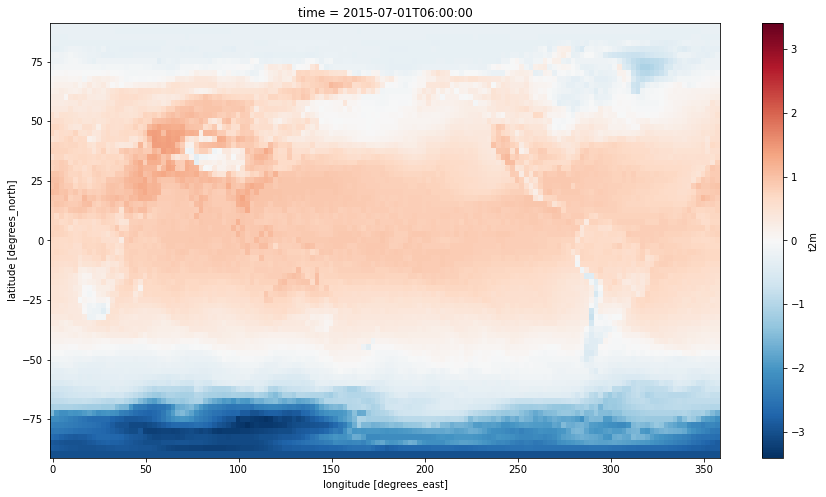

In [100]:
fig, ax = plt.subplots(figsize=(15, 8))
std_t2m.isel(time=1).plot()

## Section 4 - "Big data"

Most of the times when working with climate data, we can't just fit everything into memory. Using a complete year of reanalysis at the hour level is close to the 30Gb, and having multiple years can easily become into a 1 Tb ordeal. Luckily, `xarray` is well integrated with Dask. 

### What is Dask? 

`Dask` is a tool that allows scalable computing using chunks of data in both local processing and distributed computing (i.e. using a cluster like `Midway2`). The way Dask execute data processing is by dividing large datasets into user-defined chunks, and creating `future` values. This means, Dask will _lazy_ load data and even when executing functions, will only create a "roadmap" without computing (_lazy computing_).

In [101]:
from dask.distributed import Client

client = Client()
client

/usr/local/lib/python3.6/dist-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://127.0.0.1:40965 Dashboard: http://127.0.0.1:42757/status,Cluster Workers: 2 Cores: 2 Memory: 13.65 GB


In [ ]:
xr_era = xr.open_mfdataset(os.path.join(loaddir, 'era_5_example.nc4'),
                           chunks={'time': 1})
xr_era

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/usr/local/lib/python3.6/dist-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


,Array,Chunk
Bytes,5.21 MB,42.05 kB
Shape,"(124, 73, 144)","(1, 73, 144)"
Count,125 Tasks,124 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,5.21 MB,42.05 kB
Shape,"(124, 73, 144)","(1, 73, 144)"
Count,125 Tasks,124 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [ ]:
xr_era.t2m

,Array,Chunk
Bytes,5.21 MB,42.05 kB
Shape,"(124, 73, 144)","(1, 73, 144)"
Count,125 Tasks,124 Chunks
Type,float32,numpy.ndarray


In [ ]:
xr_era.t2m.mean()

<xarray.DataArray 't2m' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

In [ ]:
xr_era.t2m.compute()

CancelledError: ignored

Drive doesn't play nicely with Dask :(  Time to jump to `Midway2`!